****MAE 250F, HW 5 #4****
<br>****David L. Tran****
<br>****ID: 205-492-874****
<br> ****NOTE:**** Answers to 4b-4f are below.

In [11]:
using FluidDynTools
using PotentialFlow
using Plots

In [12]:
function compute_ẋ!(ẋ, x, t)
        
    # Zero the velocity
    reset_velocity!(ẋ, x)
    
    # Compute the self-induced velocity of the system
    self_induce_velocity!(ẋ, x, t)
    
end

compute_ẋ! (generic function with 1 method)

In [16]:
"""
    vortex_patch!(vort,zc,Γ,radius,nring[,ϵ=0])

Create a circular patch of vortex blobs, returned in `vort`. The centroid of the patch is at `zc`, its strength
(circulation) is `Γ`, and its radius is `radius`. The patch consists of `nring` rings; if `nring = 1`, the patch
consists of only a single vortex blob at the centroid. Each blob is assigned radius `ϵ`, which is 0 by default.
"""
function vortex_patch!(vort,zc,Γ,radius,nring::Int;ϵ=0)
    Δr = radius/(nring-1/2)
    dΓ = Γ/(1+8*nring*(nring-1)/2)
    push!(vort,Vortex.Blob(zc,dΓ,ϵ))
    for ir in 1:nring-1
        nθ = 8*ir
        for j = 0:nθ-1
            push!(vort,Vortex.Blob(zc + ir*Δr*exp(im*2π*j/nθ),dΓ,ϵ))
        end
    end
    return vort
end

"""
    vortex_patch(zc,Γ,radius,nring[,δ=0]) -> Vector{Vortex.Blob}

Create a circular patch of vortex blobs. The centroid of the patch is at `zc`, its strength
(circulation) is `Γ`, and its radius is `radius`. The patch consists of `nring` rings; if `nring = 1`, the patch
consists of only a single vortex blob at the centroid. Each blob is assigned radius `δ`, which is 0 by default.
"""
vortex_patch(zc,Γ,radius,nring::Int;ϵ=0) = vortex_patch!(Vortex.Blob{Float64,Float64}[],zc,Γ,radius,nring,ϵ=ϵ)

vortex_patch

In [17]:
r01 = r02 = 0.275 # initial radius of the vortex patch

d0 = 1.0  # initial distance between patch centroids

Γ01 = Γ02 = 1.0 # strength of patch.

nring = 1   # number of rings in each patch.

ϵ = 0.01 # blob radius

Δt = 0.01*π^2*d0^2/abs(Γ01) # set the time step
nothing

In [18]:
t = 0.0
sys = (vortex_patch(0.5im*d0,Γ01,r01,nring,ϵ=ϵ),
       vortex_patch(-0.5im*d0,Γ02,r02,nring,ϵ=ϵ))
npatch = length(sys);

In [19]:
# Used for storage during time-marching
sys₊ = deepcopy(sys)

history = [deepcopy(sys)]

# Set up a velocity structure that will work for 4th-order Runge-Kutta
ẋs = [allocate_velocity(sys) for k = 1:4];

# To keep track of time
thist = [0.0];

In [21]:
tf = 10
T = 0:Δt:tf-Δt

for tloc in T
    TimeMarching.rk4!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)
    
    sys₊, sys = sys, sys₊
    
    t += Δt
    
    push!(history,deepcopy(sys))
    push!(thist,t)
end    

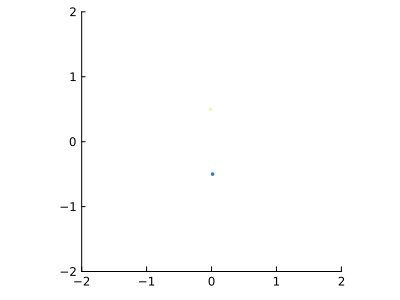

In [22]:
# Choose with snapshot to plot. You can get different snapshots by putting in different indices
# to the history array. `end` just chooses the last entry.
sys_to_plot = history[end] 

plot(ratio=1,legend=:none,xlims = (-2,2), ylims = (-2,2), markerstrokewidth=0, markersize=2)

# This plots patch number 1. The marker_z option gives the patch a distinct color.
plot!(sys_to_plot[1],markerstrokewidth=0, markersize=2, marker_z = -1, color= cgrad(:YlGnBu_3,rev=true))

# This plots patch number 2
plot!(sys_to_plot[2],markerstrokewidth=0, markersize=2, marker_z = 1, color= cgrad(:YlGnBu_3,rev=true))


# If you want to save a figure, you can use the savefig function
#savefig("FigName.pdf") 

In [23]:
function trajectory(history,patch::Int,elementID::Int)
    elementID > length(history[end][patch]) && error("Element ID out of range")
    track = map(sys -> Elements.position(sys[patch])[elementID],history)
end

trajectory (generic function with 1 method)

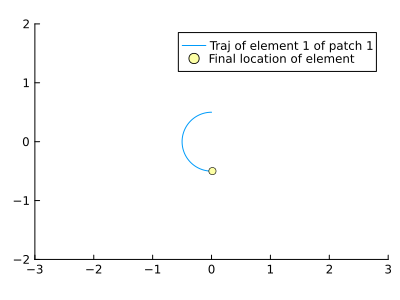

In [24]:
ps = plot(ratio=1,legend=:none,xlims = (-3,3), ylims = (-2,2));
patch = 1
elementID = 1
traj = trajectory(history,patch,elementID)
plot!(ps,real.(traj),imag.(traj),label="Traj of element "*string(elementID)*" of patch "*string(patch));
plot!(ps,history[end][patch][elementID:elementID],legend=true,label="Final location of element")

In [25]:
function patch_impulse_history(history,patch::Int)
    imp = map(sys -> Elements.impulse(sys[patch]),history)
end

patch_impulse_history (generic function with 1 method)

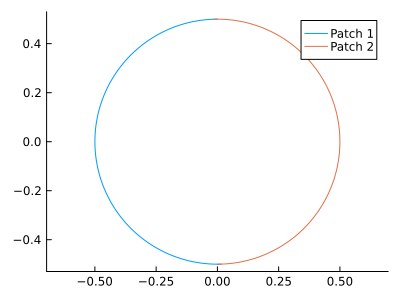

In [26]:
cent1 = im*patch_impulse_history(history,1)/Γ01
cent2 = im*patch_impulse_history(history,2)/Γ02

plot(real.(cent1),imag.(cent1),ratio=1,label="Patch 1",legend=true)
plot!(real.(cent2),imag.(cent2),label="Patch 2")

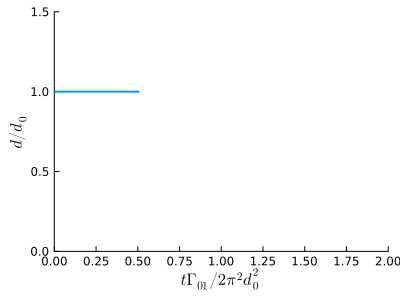

In [27]:
plot(xlim=(0,2),ylim=(0,1.5),xticks=(0:0.25:2),legend=:false)
plot!(Γ01*thist/(2π^2*d0^2),abs.(cent2-cent1),linewidth=2)
plot!(xlabel=L"tΓ_{01}/2π^2d_0^2",ylabel=L"d/d_0") # if this line fails, just comment it out
#savefig("CoRotateDCentroid.pdf")

****(4b)**** We can see that the $2\pi^2d_0^2/\Gamma_0$ time from (4a) to complete one orbit is correct from the above plot.

In [74]:
r01 = r02 = 0.2

d0 = 1.0  # initial distance between patch centroids

Γ01 = Γ02 = 1.0 # strength of patch.

nring = 10   # number of rings in each patch.

ϵ = 0.01 # blob radius

Δt = 0.01*π^2*d0^2/abs(Γ01) # set the time step
nothing

In [75]:
t = 0.0
sys = (vortex_patch(0.5im*d0,Γ01,r01,nring,ϵ=ϵ),
       vortex_patch(-0.5im*d0,Γ02,r02,nring,ϵ=ϵ))
npatch = length(sys);

In [76]:
# Used for storage during time-marching
sys₊ = deepcopy(sys)

history = [deepcopy(sys)]

# Set up a velocity structure that will work for 4th-order Runge-Kutta
ẋs = [allocate_velocity(sys) for k = 1:4];

# To keep track of time
thist = [0.0];

In [77]:
tf = 10
T = 0:Δt:tf-Δt

for tloc in T
    TimeMarching.rk4!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)
    
    sys₊, sys = sys, sys₊
    
    t += Δt
    
    push!(history,deepcopy(sys))
    push!(thist,t)
    
end

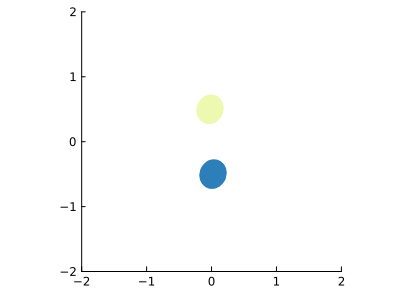

In [78]:
sys_to_plot = history[end] 

plot(ratio=1,legend=:none,xlims = (-2,2), ylims = (-2,2), markerstrokewidth=0, markersize=2)

# This plots patch number 1. The marker_z option gives the patch a distinct color.
plot!(sys_to_plot[1],markerstrokewidth=0, markersize=2, marker_z = -1, color= cgrad(:YlGnBu_3,rev=true))

# This plots patch number 2
plot!(sys_to_plot[2],markerstrokewidth=0, markersize=2, marker_z = 1, color= cgrad(:YlGnBu_3,rev=true))

In [79]:
function trajectory(history,patch::Int,elementID::Int)
    elementID > length(history[end][patch]) && error("Element ID out of range")
    track = map(sys -> Elements.position(sys[patch])[elementID],history)
end

trajectory (generic function with 1 method)

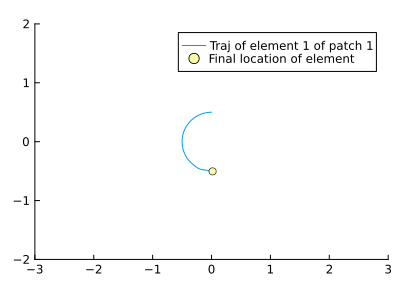

In [80]:
ps = plot(ratio=1,legend=:none,xlims = (-3,3), ylims = (-2,2));
patch = 1
elementID = 1
traj = trajectory(history,patch,elementID)
plot!(ps,real.(traj),imag.(traj),label="Traj of element "*string(elementID)*" of patch "*string(patch));
plot!(ps,history[end][patch][elementID:elementID],legend=true,label="Final location of element")

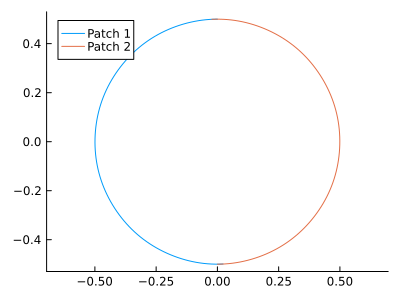

In [81]:
function patch_impulse_history(history,patch::Int)
    imp = map(sys -> Elements.impulse(sys[patch]),history)
end

cent1 = im*patch_impulse_history(history,1)/Γ01
cent2 = im*patch_impulse_history(history,2)/Γ02

plot(real.(cent1),imag.(cent1),ratio=1,label="Patch 1",legend=true)
plot!(real.(cent2),imag.(cent2),label="Patch 2")

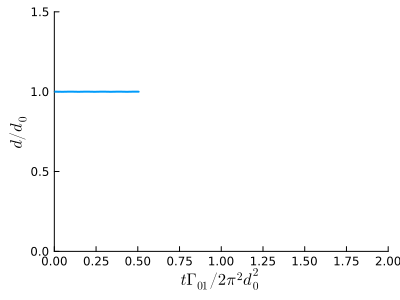

In [82]:
plot(xlim=(0,2),ylim=(0,1.5),xticks=(0:0.25:2),legend=:false)
plot!(Γ01*thist/(2π^2*d0^2),abs.(cent2-cent1),linewidth=2)
plot!(xlabel=L"tΓ_{01}/2π^2d_0^2",ylabel=L"d/d_0") # if this line fails, just comment it out
#savefig("CoRotateDCentroid.pdf")

****(4ci)**** For the case where $r_0=0.2$, the centroid plot is a complete circle and the $d/d_0$ remains a constant. But, changing to $r_0=0.3$, we can see that the centroid plot indicates the two eventually colliding with each other at the origin; this is reflective in the $d/d_0$ plot decreasing to 0. If we increase to $r_0=0.4$, the centroids will continue to interact, and they will no longer be at the center.

In [83]:
r01 = r02 = 0.3

d0 = 1.0  # initial distance between patch centroids

Γ01 = Γ02 = 1.0 # strength of patch.

nring = 10   # number of rings in each patch.

ϵ = 0.01 # blob radius

Δt = 0.01*π^2*d0^2/abs(Γ01) # set the time step
nothing

In [84]:
t = 0.0
sys = (vortex_patch(0.5im*d0,Γ01,r01,nring,ϵ=ϵ),
       vortex_patch(-0.5im*d0,Γ02,r02,nring,ϵ=ϵ))
npatch = length(sys);

In [85]:
# Used for storage during time-marching
sys₊ = deepcopy(sys)

history = [deepcopy(sys)]

# Set up a velocity structure that will work for 4th-order Runge-Kutta
ẋs = [allocate_velocity(sys) for k = 1:4];

# To keep track of time
thist = [0.0];

In [90]:
tf = 10
T = 0:Δt:tf-Δt

for tloc in T
    TimeMarching.rk4!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)
    
    sys₊, sys = sys, sys₊
    
    t += Δt
    
    push!(history,deepcopy(sys))
    push!(thist,t)
    
end

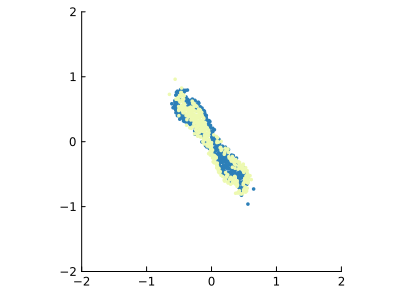

In [91]:
sys_to_plot = history[end] 

plot(ratio=1,legend=:none,xlims = (-2,2), ylims = (-2,2), markerstrokewidth=0, markersize=2)

# This plots patch number 1. The marker_z option gives the patch a distinct color.
plot!(sys_to_plot[1],markerstrokewidth=0, markersize=2, marker_z = -1, color= cgrad(:YlGnBu_3,rev=true))

# This plots patch number 2
plot!(sys_to_plot[2],markerstrokewidth=0, markersize=2, marker_z = 1, color= cgrad(:YlGnBu_3,rev=true))

In [92]:
function trajectory(history,patch::Int,elementID::Int)
    elementID > length(history[end][patch]) && error("Element ID out of range")
    track = map(sys -> Elements.position(sys[patch])[elementID],history)
end

trajectory (generic function with 1 method)

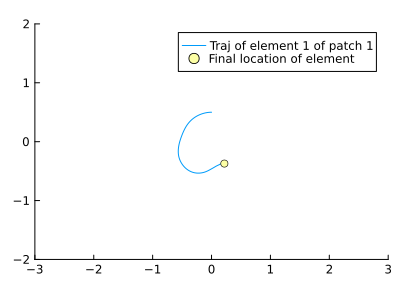

In [93]:
ps = plot(ratio=1,legend=:none,xlims = (-3,3), ylims = (-2,2));
patch = 1
elementID = 1
traj = trajectory(history,patch,elementID)
plot!(ps,real.(traj),imag.(traj),label="Traj of element "*string(elementID)*" of patch "*string(patch));
plot!(ps,history[end][patch][elementID:elementID],legend=true,label="Final location of element")

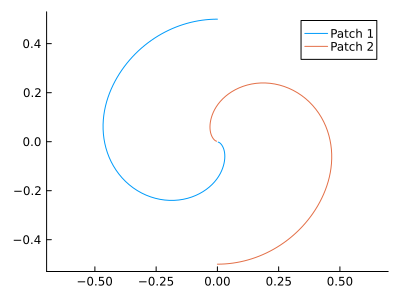

In [94]:
function patch_impulse_history(history,patch::Int)
    imp = map(sys -> Elements.impulse(sys[patch]),history)
end

cent1 = im*patch_impulse_history(history,1)/Γ01
cent2 = im*patch_impulse_history(history,2)/Γ02

plot(real.(cent1),imag.(cent1),ratio=1,label="Patch 1",legend=true)
plot!(real.(cent2),imag.(cent2),label="Patch 2")

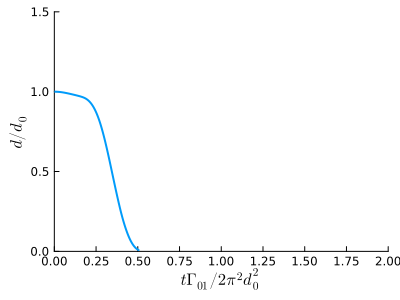

In [95]:
plot(xlim=(0,2),ylim=(0,1.5),xticks=(0:0.25:2),legend=:false)
plot!(Γ01*thist/(2π^2*d0^2),abs.(cent2-cent1),linewidth=2)
plot!(xlabel=L"tΓ_{01}/2π^2d_0^2",ylabel=L"d/d_0") # if this line fails, just comment it out
#savefig("CoRotateDCentroid.pdf")

****(4cii)**** We can change the number of rings to 20 and see if it has any effect:

In [96]:
r01 = r02 = 0.3

d0 = 1.0  # initial distance between patch centroids

Γ01 = Γ02 = 1.0 # strength of patch.

nring = 20   # number of rings in each patch.

ϵ = 0.01 # blob radius

Δt = 0.01*π^2*d0^2/abs(Γ01) # set the time step
nothing

In [97]:
t = 0.0
sys = (vortex_patch(0.5im*d0,Γ01,r01,nring,ϵ=ϵ),
       vortex_patch(-0.5im*d0,Γ02,r02,nring,ϵ=ϵ))
npatch = length(sys);

In [98]:
sys₊ = deepcopy(sys)

history = [deepcopy(sys)]

# Set up a velocity structure that will work for 4th-order Runge-Kutta
ẋs = [allocate_velocity(sys) for k = 1:4];

# To keep track of time
thist = [0.0];

In [99]:
tf = 10
T = 0:Δt:tf-Δt

for tloc in T
    TimeMarching.rk4!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)
    
    sys₊, sys = sys, sys₊
    
    t += Δt
    
    push!(history,deepcopy(sys))
    push!(thist,t)
    
end

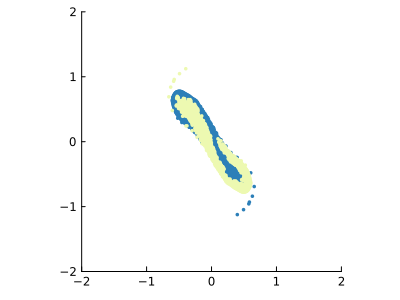

In [100]:
sys_to_plot = history[end] 

plot(ratio=1,legend=:none,xlims = (-2,2), ylims = (-2,2), markerstrokewidth=0, markersize=2)

# This plots patch number 1. The marker_z option gives the patch a distinct color.
plot!(sys_to_plot[1],markerstrokewidth=0, markersize=2, marker_z = -1, color= cgrad(:YlGnBu_3,rev=true))

# This plots patch number 2
plot!(sys_to_plot[2],markerstrokewidth=0, markersize=2, marker_z = 1, color= cgrad(:YlGnBu_3,rev=true))

In [101]:
function trajectory(history,patch::Int,elementID::Int)
    elementID > length(history[end][patch]) && error("Element ID out of range")
    track = map(sys -> Elements.position(sys[patch])[elementID],history)
end

trajectory (generic function with 1 method)

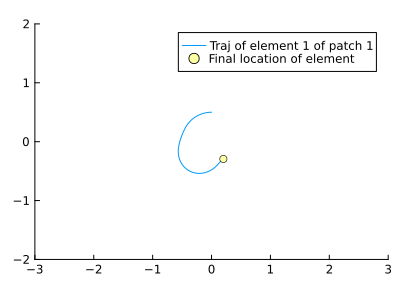

In [102]:
ps = plot(ratio=1,legend=:none,xlims = (-3,3), ylims = (-2,2));
patch = 1
elementID = 1
traj = trajectory(history,patch,elementID)
plot!(ps,real.(traj),imag.(traj),label="Traj of element "*string(elementID)*" of patch "*string(patch));
plot!(ps,history[end][patch][elementID:elementID],legend=true,label="Final location of element")

In [103]:
function patch_impulse_history(history,patch::Int)
    imp = map(sys -> Elements.impulse(sys[patch]),history)
end

patch_impulse_history (generic function with 1 method)

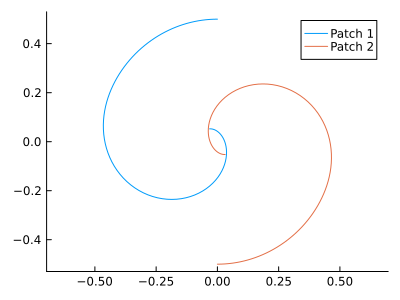

In [104]:
cent1 = im*patch_impulse_history(history,1)/Γ01
cent2 = im*patch_impulse_history(history,2)/Γ02

plot(real.(cent1),imag.(cent1),ratio=1,label="Patch 1",legend=true)
plot!(real.(cent2),imag.(cent2),label="Patch 2")

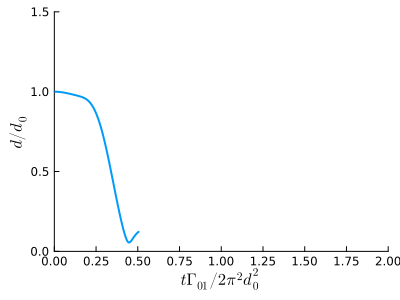

In [105]:
plot(xlim=(0,2),ylim=(0,1.5),xticks=(0:0.25:2),legend=:false)
plot!(Γ01*thist/(2π^2*d0^2),abs.(cent2-cent1),linewidth=2)
plot!(xlabel=L"tΓ_{01}/2π^2d_0^2",ylabel=L"d/d_0") # if this line fails, just comment it out
#savefig("CoRotateDCentroid.pdf")

****(4cii)**** Interestingly, we can see that increasing the number of rings to nrings = 20 had an effect on the $d/d_0$ plot. The $r_0$ critical value is now lower than when it was at nrings = 10.

****(4ciii)**** Doubling the blob radius to $\epsilon=0.02$, the following results are produced.

In [106]:
r01 = r02 = 0.3 # initial radius of the vortex patch

d0 = 1.0  # initial distance between patch centroids

Γ01 = Γ02 = 1.0 # strength of patch.

nring = 10   # number of rings in each patch.

ϵ = 0.02 # blob radius

Δt = 0.01*π^2*d0^2/abs(Γ01) # set the time step
nothing

In [107]:
t = 0.0
sys = (vortex_patch(0.5im*d0,Γ01,r01,nring,ϵ=ϵ),
       vortex_patch(-0.5im*d0,Γ02,r02,nring,ϵ=ϵ))
npatch = length(sys);

In [108]:
sys₊ = deepcopy(sys)

history = [deepcopy(sys)]

# Set up a velocity structure that will work for 4th-order Runge-Kutta
ẋs = [allocate_velocity(sys) for k = 1:4];

# To keep track of time
thist = [0.0];

In [109]:
tf = 10
T = 0:Δt:tf-Δt

for tloc in T
    TimeMarching.rk4!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)
    
    sys₊, sys = sys, sys₊
    
    t += Δt
    
    push!(history,deepcopy(sys))
    push!(thist,t)
    
end

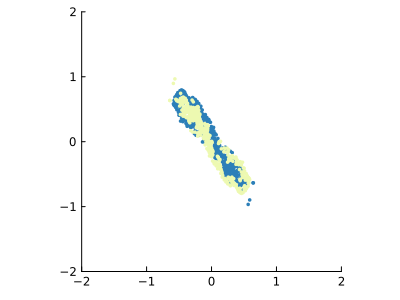

In [110]:
sys_to_plot = history[end] 

plot(ratio=1,legend=:none,xlims = (-2,2), ylims = (-2,2), markerstrokewidth=0, markersize=2)

# This plots patch number 1. The marker_z option gives the patch a distinct color.
plot!(sys_to_plot[1],markerstrokewidth=0, markersize=2, marker_z = -1, color= cgrad(:YlGnBu_3,rev=true))

# This plots patch number 2
plot!(sys_to_plot[2],markerstrokewidth=0, markersize=2, marker_z = 1, color= cgrad(:YlGnBu_3,rev=true))

In [111]:
function trajectory(history,patch::Int,elementID::Int)
    elementID > length(history[end][patch]) && error("Element ID out of range")
    track = map(sys -> Elements.position(sys[patch])[elementID],history)
end

trajectory (generic function with 1 method)

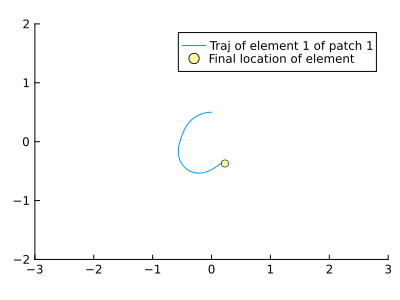

In [112]:
ps = plot(ratio=1,legend=:none,xlims = (-3,3), ylims = (-2,2));
patch = 1
elementID = 1
traj = trajectory(history,patch,elementID)
plot!(ps,real.(traj),imag.(traj),label="Traj of element "*string(elementID)*" of patch "*string(patch));
plot!(ps,history[end][patch][elementID:elementID],legend=true,label="Final location of element")

In [113]:
function patch_impulse_history(history,patch::Int)
    imp = map(sys -> Elements.impulse(sys[patch]),history)
end

patch_impulse_history (generic function with 1 method)

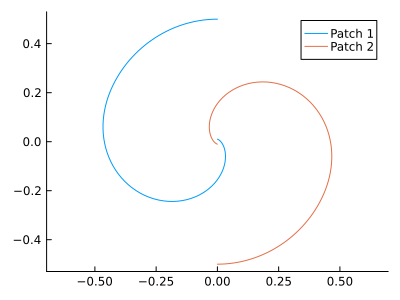

In [114]:
cent1 = im*patch_impulse_history(history,1)/Γ01
cent2 = im*patch_impulse_history(history,2)/Γ02

plot(real.(cent1),imag.(cent1),ratio=1,label="Patch 1",legend=true)
plot!(real.(cent2),imag.(cent2),label="Patch 2")

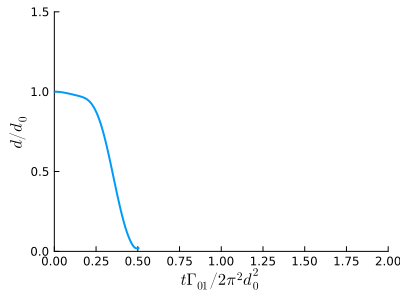

In [115]:
plot(xlim=(0,2),ylim=(0,1.5),xticks=(0:0.25:2),legend=:false)
plot!(Γ01*thist/(2π^2*d0^2),abs.(cent2-cent1),linewidth=2)
plot!(xlabel=L"tΓ_{01}/2π^2d_0^2",ylabel=L"d/d_0") # if this line fails, just comment it out
#savefig("CoRotateDCentroid.pdf")

****(4ciii)**** Doubling the blob radius had a very minimal impact on the results, but they are somewhat noticeable. Perhaps if $\epsilon$ was increased by a larger factor, a greater impact may be noticed.

****(4d)**** For patches of equal but opposite strength, we simply set one with $-\Gamma$ and the other with $\Gamma$. So,

In [116]:
r01 = r02 = 0.3 # initial radius of the vortex patch

d0 = 1.0  # initial distance between patch centroids

Γ01 = 1.0 # strength of patch.
Γ02 = -1.0

nring = 10   # number of rings in each patch.

ϵ = 0.01 # blob radius

Δt = 0.01*π^2*d0^2/abs(Γ01) # set the time step
nothing

In [117]:
t = 0.0
sys = (vortex_patch(0.5im*d0,Γ01,r01,nring,ϵ=ϵ),
       vortex_patch(-0.5im*d0,Γ02,r02,nring,ϵ=ϵ))
npatch = length(sys);

In [118]:
# Used for storage during time-marching
sys₊ = deepcopy(sys)

history = [deepcopy(sys)]

# Set up a velocity structure that will work for 4th-order Runge-Kutta
ẋs = [allocate_velocity(sys) for k = 1:4];

# To keep track of time
thist = [0.0];

In [119]:
tf = 10
T = 0:Δt:tf-Δt

for tloc in T
    TimeMarching.rk4!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)
    
    sys₊, sys = sys, sys₊
    
    t += Δt
    
    push!(history,deepcopy(sys))
    push!(thist,t)
    
end

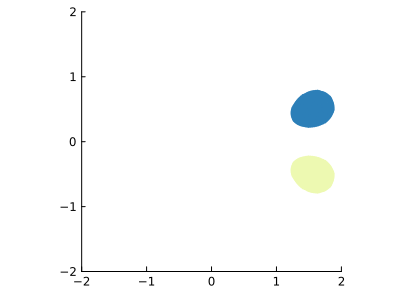

In [120]:
sys_to_plot = history[end] 

plot(ratio=1,legend=:none,xlims = (-2,2), ylims = (-2,2), markerstrokewidth=0, markersize=2)

# This plots patch number 1. The marker_z option gives the patch a distinct color.
plot!(sys_to_plot[1],markerstrokewidth=0, markersize=2, marker_z = -1, color= cgrad(:YlGnBu_3,rev=true))

# This plots patch number 2
plot!(sys_to_plot[2],markerstrokewidth=0, markersize=2, marker_z = 1, color= cgrad(:YlGnBu_3,rev=true))


In [121]:
function trajectory(history,patch::Int,elementID::Int)
    elementID > length(history[end][patch]) && error("Element ID out of range")
    track = map(sys -> Elements.position(sys[patch])[elementID],history)
end

trajectory (generic function with 1 method)

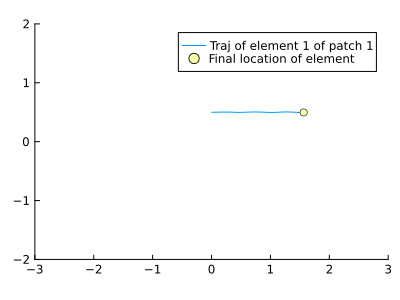

In [124]:
ps = plot(ratio=1,legend=:none,xlims = (-3,3), ylims = (-2,2));
patch = 1
elementID = 1
traj = trajectory(history,patch,elementID)
plot!(ps,real.(traj),imag.(traj),label="Traj of element "*string(elementID)*" of patch "*string(patch));
plot!(ps,history[end][patch][elementID:elementID],legend=true,label="Final location of element")

In [122]:
function patch_impulse_history(history,patch::Int)
    imp = map(sys -> Elements.impulse(sys[patch]),history)
end

patch_impulse_history (generic function with 1 method)

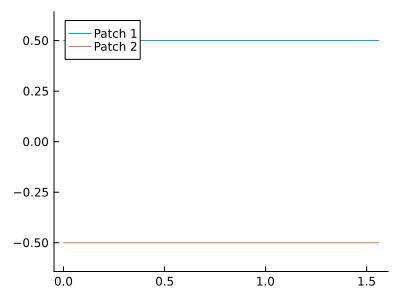

In [123]:
cent1 = im*patch_impulse_history(history,1)/Γ01
cent2 = im*patch_impulse_history(history,2)/Γ02

plot(real.(cent1),imag.(cent1),ratio=1,label="Patch 1",legend=true)
plot!(real.(cent2),imag.(cent2),label="Patch 2")

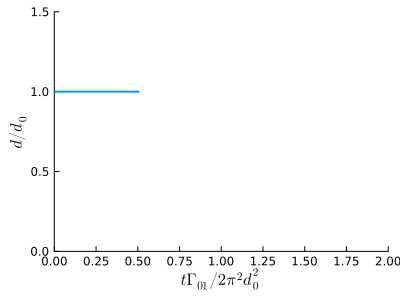

In [125]:
plot(xlim=(0,2),ylim=(0,1.5),xticks=(0:0.25:2),legend=:false)
plot!(Γ01*thist/(2π^2*d0^2),abs.(cent2-cent1),linewidth=2)
plot!(xlabel=L"tΓ_{01}/2π^2d_0^2",ylabel=L"d/d_0") # if this line fails, just comment it out
#savefig("CoRotateDCentroid.pdf")

****(4d)**** The two vortices cancel each other and the distance between the centroids remains at $d=d_0$ throughout the time.

****(4ei)**** For a square vortex patch, we have:

In [128]:
r01 = r02 = r03 = r04 = 0.3 # initial radius of the vortex patch

d0 = 1.0  # initial distance between patch centroids

Γ01 = Γ02 = 1.0 # strength of patch.
Γ03 = Γ04 = -1.0

nring = 1   # number of rings in each patch.

ϵ = 0.01 # blob radius

Δt = 0.01*π^2*d0^2/abs(Γ01) # set the time step
nothing

In [138]:
t = 0.0
sys = (vortex_patch(-0.5*d0+0.5im*d0,Γ01,r01,nring,ϵ=ϵ),
       vortex_patch(0.5*d0+0.5im*d0,Γ02,r02,nring,ϵ=ϵ),
       vortex_patch(-0.5*d0-0.5im*d0,Γ03,r03,nring,ϵ=ϵ),
       vortex_patch(0.5*d0-0.5im*d0,Γ04,r04,nring,ϵ=ϵ))
npatch = length(sys);

In [139]:
sys₊ = deepcopy(sys)

history = [deepcopy(sys)]

# Set up a velocity structure that will work for 4th-order Runge-Kutta
ẋs = [allocate_velocity(sys) for k = 1:4];

# To keep track of time
thist = [0.0];

In [140]:
tf = 10
T = 0:Δt:tf-Δt

for tloc in T
    TimeMarching.rk4!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)
    
    sys₊, sys = sys, sys₊
    
    t += Δt
    
    push!(history,deepcopy(sys))
    push!(thist,t)
    
end

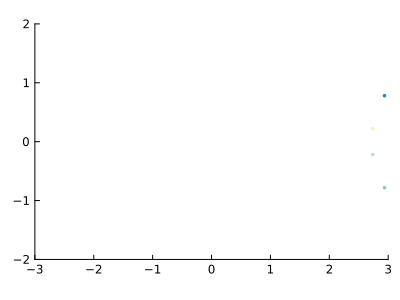

In [144]:
sys_to_plot = history[end] 

plot(ratio=1,legend=:none,xlims = (-3,3), ylims = (-2,2), markerstrokewidth=0, markersize=2)

# This plots patch number 1. The marker_z option gives the patch a distinct color.
plot!(sys_to_plot[1],markerstrokewidth=0, markersize=2, marker_z = -1, color= cgrad(:YlGnBu_3,rev=true))

# This plots patch number 2
plot!(sys_to_plot[2],markerstrokewidth=0, markersize=2, marker_z = 1, color= cgrad(:YlGnBu_3,rev=true))

plot!(sys_to_plot[3],markerstrokewidth=0, markersize=2, marker_z = 0, color= cgrad(:YlGnBu_3,rev=true))

plot!(sys_to_plot[4],markerstrokewidth=0, markersize=2, marker_z = 0.5, color= cgrad(:YlGnBu_3,rev=true))

In [145]:
function trajectory(history,patch::Int,elementID::Int)
    elementID > length(history[end][patch]) && error("Element ID out of range")
    track = map(sys -> Elements.position(sys[patch])[elementID],history)
end

trajectory (generic function with 1 method)

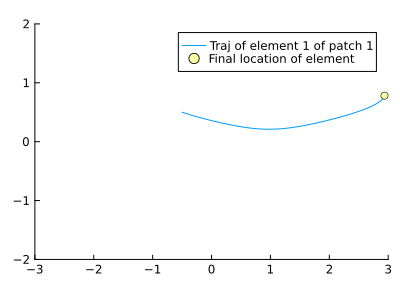

In [146]:
ps = plot(ratio=1,legend=:none,xlims = (-3,3), ylims = (-2,2));
patch = 1
elementID = 1
traj = trajectory(history,patch,elementID)
plot!(ps,real.(traj),imag.(traj),label="Traj of element "*string(elementID)*" of patch "*string(patch));
plot!(ps,history[end][patch][elementID:elementID],legend=true,label="Final location of element")

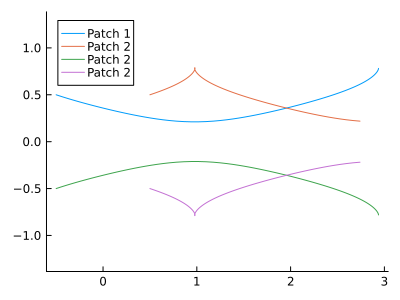

In [148]:
function patch_impulse_history(history,patch::Int)
    imp = map(sys -> Elements.impulse(sys[patch]),history)
end

cent1 = im*patch_impulse_history(history,1)/Γ01
cent2 = im*patch_impulse_history(history,2)/Γ02
cent3 = im*patch_impulse_history(history,3)/Γ03
cent4 = im*patch_impulse_history(history,4)/Γ04

plot(real.(cent1),imag.(cent1),ratio=1,label="Patch 1",legend=true)
plot!(real.(cent2),imag.(cent2),label="Patch 2")
plot!(real.(cent3),imag.(cent3),label="Patch 3")
plot!(real.(cent4),imag.(cent4),label="Patch 4")

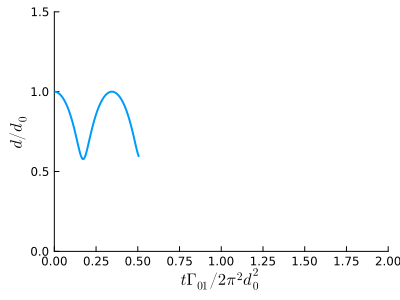

In [149]:
plot(xlim=(0,2),ylim=(0,1.5),xticks=(0:0.25:2),legend=:false)
plot!(Γ01*thist/(2π^2*d0^2),abs.(cent2-cent1),linewidth=2)
plot!(xlabel=L"tΓ_{01}/2π^2d_0^2",ylabel=L"d/d_0") # if this line fails, just comment it out

****(4ei)**** The point vortices mirror each across the horizontal axis (i.e., the pair of top vortices mirrors the pair of bottom vortices). The $d/d_0$ is also sinusoidal in nature, fluctuating back and forth ad nauseum.

****(4eii)**** For nrings = 10, the following results are produced.

In [150]:
r01 = r02 = r03 = r04 = 0.3 # initial radius of the vortex patch

d0 = 1.0  # initial distance between patch centroids

Γ01 = Γ02 = 1.0 # strength of patch.
Γ03 = Γ04 = -1.0

nring = 10   # number of rings in each patch.

ϵ = 0.01 # blob radius

Δt = 0.01*π^2*d0^2/abs(Γ01) # set the time step
nothing

In [151]:
t = 0.0
sys = (vortex_patch(-0.5*d0+0.5im*d0,Γ01,r01,nring,ϵ=ϵ),
       vortex_patch(0.5*d0+0.5im*d0,Γ02,r02,nring,ϵ=ϵ),
       vortex_patch(-0.5*d0-0.5im*d0,Γ03,r03,nring,ϵ=ϵ),
       vortex_patch(0.5*d0-0.5im*d0,Γ04,r04,nring,ϵ=ϵ))
npatch = length(sys);

In [152]:
sys₊ = deepcopy(sys)

history = [deepcopy(sys)]

# Set up a velocity structure that will work for 4th-order Runge-Kutta
ẋs = [allocate_velocity(sys) for k = 1:4];

# To keep track of time
thist = [0.0];

In [153]:
tf = 10
T = 0:Δt:tf-Δt

for tloc in T
    TimeMarching.rk4!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)
    
    sys₊, sys = sys, sys₊
    
    t += Δt
    
    push!(history,deepcopy(sys))
    push!(thist,t)
    
end

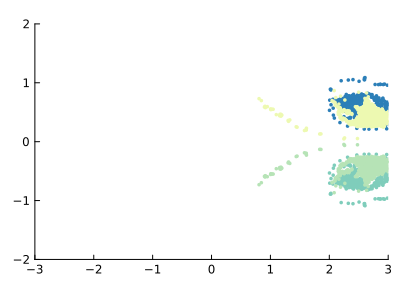

In [154]:
sys_to_plot = history[end] 

plot(ratio=1,legend=:none,xlims = (-3,3), ylims = (-2,2), markerstrokewidth=0, markersize=2)

# This plots patch number 1. The marker_z option gives the patch a distinct color.
plot!(sys_to_plot[1],markerstrokewidth=0, markersize=2, marker_z = -1, color= cgrad(:YlGnBu_3,rev=true))

# This plots patch number 2
plot!(sys_to_plot[2],markerstrokewidth=0, markersize=2, marker_z = 1, color= cgrad(:YlGnBu_3,rev=true))

plot!(sys_to_plot[3],markerstrokewidth=0, markersize=2, marker_z = 0, color= cgrad(:YlGnBu_3,rev=true))

plot!(sys_to_plot[4],markerstrokewidth=0, markersize=2, marker_z = 0.5, color= cgrad(:YlGnBu_3,rev=true))

In [155]:
function trajectory(history,patch::Int,elementID::Int)
    elementID > length(history[end][patch]) && error("Element ID out of range")
    track = map(sys -> Elements.position(sys[patch])[elementID],history)
end

trajectory (generic function with 1 method)

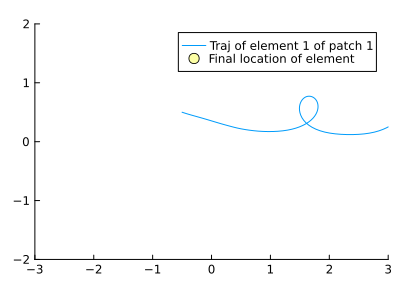

In [156]:
ps = plot(ratio=1,legend=:none,xlims = (-3,3), ylims = (-2,2));
patch = 1
elementID = 1
traj = trajectory(history,patch,elementID)
plot!(ps,real.(traj),imag.(traj),label="Traj of element "*string(elementID)*" of patch "*string(patch));
plot!(ps,history[end][patch][elementID:elementID],legend=true,label="Final location of element")

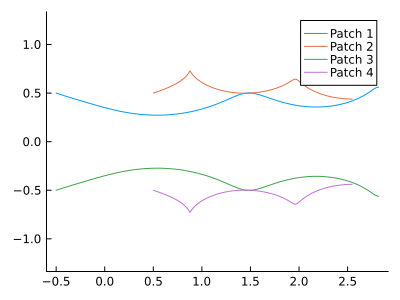

In [157]:
function patch_impulse_history(history,patch::Int)
    imp = map(sys -> Elements.impulse(sys[patch]),history)
end

cent1 = im*patch_impulse_history(history,1)/Γ01
cent2 = im*patch_impulse_history(history,2)/Γ02
cent3 = im*patch_impulse_history(history,3)/Γ03
cent4 = im*patch_impulse_history(history,4)/Γ04

plot(real.(cent1),imag.(cent1),ratio=1,label="Patch 1",legend=true)
plot!(real.(cent2),imag.(cent2),label="Patch 2")
plot!(real.(cent3),imag.(cent3),label="Patch 3")
plot!(real.(cent4),imag.(cent4),label="Patch 4")

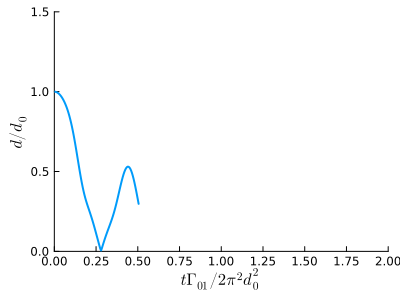

In [158]:
plot(xlim=(0,2),ylim=(0,1.5),xticks=(0:0.25:2),legend=:false)
plot!(Γ01*thist/(2π^2*d0^2),abs.(cent2-cent1),linewidth=2)
plot!(xlabel=L"tΓ_{01}/2π^2d_0^2",ylabel=L"d/d_0") 

****(4eii)**** Increasing the number of patches has a drastic impact on  the $d/d_0$ plot, and this plot reaches a critical value when the time $t$ is at a radius away (i.e., $t = r_0/T = 0.3$ where $T$ is the time it takes to complete one cycle.)

****(4f)**** One final exotice case: we add a vortex at the center with circulation of strength $2\Gamma_0:$

In [160]:
r01 = r02 = r03 = r04 = r05 = 0.3 # initial radius of the vortex patch

d0 = 1.0  # initial distance between patch centroids

Γ01 = Γ02 = 1.0 # strength of patch.
Γ03 = Γ04 = -1.0
Γ05 = 2.0

nring = 1   # number of rings in each patch.

ϵ = 0.01 # blob radius

Δt = 0.01*π^2*d0^2/abs(Γ01) # set the time step
nothing

In [169]:
t = 0.0
sys = (vortex_patch(-0.5*d0+0.5im*d0,Γ01,r01,nring,ϵ=ϵ),
       vortex_patch(0.5*d0+0.5im*d0,Γ02,r02,nring,ϵ=ϵ),
       vortex_patch(-0.5*d0-0.5im*d0,Γ03,r03,nring,ϵ=ϵ),
       vortex_patch(0.5*d0-0.5im*d0,Γ04,r04,nring,ϵ=ϵ),
       vortex_patch(0,Γ05,r05,nring,ϵ=ϵ))
npatch = length(sys);

In [170]:
sys₊ = deepcopy(sys)

history = [deepcopy(sys)]

# Set up a velocity structure that will work for 4th-order Runge-Kutta
ẋs = [allocate_velocity(sys) for k = 1:4];

# To keep track of time
thist = [0.0];

In [171]:
tf = 10
T = 0:Δt:tf-Δt

for tloc in T
    TimeMarching.rk4!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)
    
    sys₊, sys = sys, sys₊
    
    t += Δt
    
    push!(history,deepcopy(sys))
    push!(thist,t)
    
end

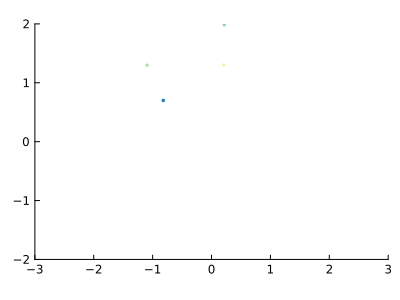

In [172]:
sys_to_plot = history[end] 

plot(ratio=1,legend=:none,xlims = (-3,3), ylims = (-2,2), markerstrokewidth=0, markersize=2)

# This plots patch number 1. The marker_z option gives the patch a distinct color.
plot!(sys_to_plot[1],markerstrokewidth=0, markersize=2, marker_z = -1, color= cgrad(:YlGnBu_3,rev=true))

# This plots patch number 2
plot!(sys_to_plot[2],markerstrokewidth=0, markersize=2, marker_z = 1, color= cgrad(:YlGnBu_3,rev=true))

plot!(sys_to_plot[3],markerstrokewidth=0, markersize=2, marker_z = 0, color= cgrad(:YlGnBu_3,rev=true))

plot!(sys_to_plot[4],markerstrokewidth=0, markersize=2, marker_z = 0.5, color= cgrad(:YlGnBu_3,rev=true))

plot!(sys_to_plot[5],markerstrokewidth=0, markersize=2, marker_z = 0.25, color= cgrad(:YlGnBu_3,rev=true))

In [173]:
function trajectory(history,patch::Int,elementID::Int)
    elementID > length(history[end][patch]) && error("Element ID out of range")
    track = map(sys -> Elements.position(sys[patch])[elementID],history)
end

trajectory (generic function with 1 method)

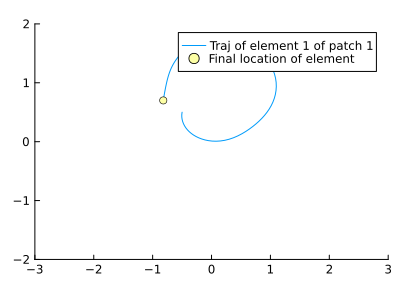

In [174]:
ps = plot(ratio=1,legend=:none,xlims = (-3,3), ylims = (-2,2));
patch = 1
elementID = 1
traj = trajectory(history,patch,elementID)
plot!(ps,real.(traj),imag.(traj),label="Traj of element "*string(elementID)*" of patch "*string(patch));
plot!(ps,history[end][patch][elementID:elementID],legend=true,label="Final location of element")

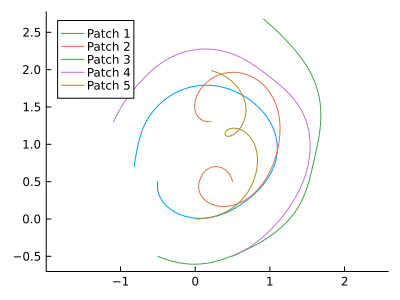

In [175]:
function patch_impulse_history(history,patch::Int)
    imp = map(sys -> Elements.impulse(sys[patch]),history)
end

cent1 = im*patch_impulse_history(history,1)/Γ01
cent2 = im*patch_impulse_history(history,2)/Γ02
cent3 = im*patch_impulse_history(history,3)/Γ03
cent4 = im*patch_impulse_history(history,4)/Γ04
cent5 = im*patch_impulse_history(history,5)/Γ05

plot(real.(cent1),imag.(cent1),ratio=1,label="Patch 1",legend=true)
plot!(real.(cent2),imag.(cent2),label="Patch 2")
plot!(real.(cent3),imag.(cent3),label="Patch 3")
plot!(real.(cent4),imag.(cent4),label="Patch 4")
plot!(real.(cent5),imag.(cent5),label="Patch 5")

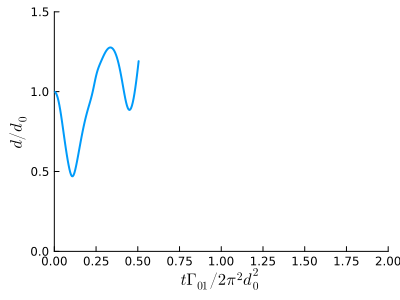

In [176]:
plot(xlim=(0,2),ylim=(0,1.5),xticks=(0:0.25:2),legend=:false)
plot!(Γ01*thist/(2π^2*d0^2),abs.(cent2-cent1),linewidth=2)
plot!(xlabel=L"tΓ_{01}/2π^2d_0^2",ylabel=L"d/d_0") 